In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
from models import WAE_MMD

In [3]:
model = WAE_MMD(in_features=41,
                hidden_dims = [41,41,41,41,41],
                latent_dim= 2,
                reg_weight = 1,
                latent_var=1,
                kernel_type = 'imq').to('cuda')

In [4]:
from datasets import OrganoidDataset
data = OrganoidDataset()
X_train,y_train = data.train
X_val,y_val = data.val

/home/egor/PycharmProjects/deep_dr/venv/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [5]:
batch_size = 4096*2

In [6]:
from torch.optim import lr_scheduler
from torch import optim

In [9]:
from tqdm import tqdm
import numpy as np


X_train_batches = torch.split(X_train,split_size_or_sections=batch_size)
X_val_batches = torch.split(X_train,split_size_or_sections=batch_size)

epochs = 200
pbar = tqdm(range(epochs))
optimizer = optim.Adam(model.parameters(),
                       lr=0.005,
                       weight_decay=0.0,
                       )
scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=0.005,
                                    steps_per_epoch=len(X_train_batches), epochs=epochs)

for epoch in pbar:
    for X_batch in X_train_batches:
        optimizer.zero_grad()
        outputs = model.forward(X_batch)
        loss = model.loss_function(*outputs)['loss']
        loss.backward()
        optimizer.step()
        scheduler.step()

    with torch.no_grad():
        losses = list()
        for X_batch in X_val_batches:
            loss_dict=dict()
            outputs = model.forward(X_batch)
            loss_val = model.loss_function(*outputs)
            loss_dict['loss'] = loss_val['loss'].to('cpu').numpy().item()
            loss_dict['Reconstruction_Loss'] = loss_val['Reconstruction_Loss'].to('cpu').numpy().item()
            loss_dict['MMD'] = loss_val['MMD'].to('cpu').numpy().item()
            losses.append(loss_dict)

        loss = np.mean([loss['loss'] for loss in losses])
        rec_loss = np.mean([loss['Reconstruction_Loss'] for loss in losses])
        mmd_loss = np.mean([loss['MMD'] for loss in losses])
        pbar.set_description(f"Epoch: {epoch}, "
                             f"Loss: {loss}, "
                             f"Reconstruction loss: {rec_loss}, "
                             f"MMD loss: {mmd_loss}", refresh=True)

print('Finished Training')

Epoch: 199, Loss: 0.368347571332856, Reconstruction loss: 0.36787333435351305, MMD loss: 0.00047423697934292333: 100%|██████████| 200/200 [40:35<00:00, 12.18s/it]  

Finished Training


In [10]:
with torch.no_grad():
    latent_val = model.encode(X_val).to('cpu')

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline

In [12]:
from datasets import CellType
reduced_dims = pd.DataFrame(y_val.cpu()).rename({0:"Cell type",1:"Day"},axis=1)
reduced_dims['Cell type'].replace({i.value: i.name for i in CellType}, inplace=True)

reduced_dims["VAE1"] = latent_val[:,0]
reduced_dims["VAE2"] = latent_val[:,1]
reduced_dims

,Cell type,Day,VAE1,VAE2
0,Enterocyte,2.0,-1.124650,-0.430652
1,Enterocyte,7.0,0.374508,0.258650
2,Tuft,5.0,-0.575524,1.058181
3,Tuft,2.0,-0.165029,1.666374
4,Stem,7.0,0.831769,-0.601867
...,...,...,...,...
234490,Stem,4.0,-0.275319,-0.880681
234491,Enterocyte,2.0,-0.612481,-0.282830
234492,Enteroendocrine,6.0,0.126164,1.331880
234493,Enterocyte,2.0,-0.647819,-0.089138


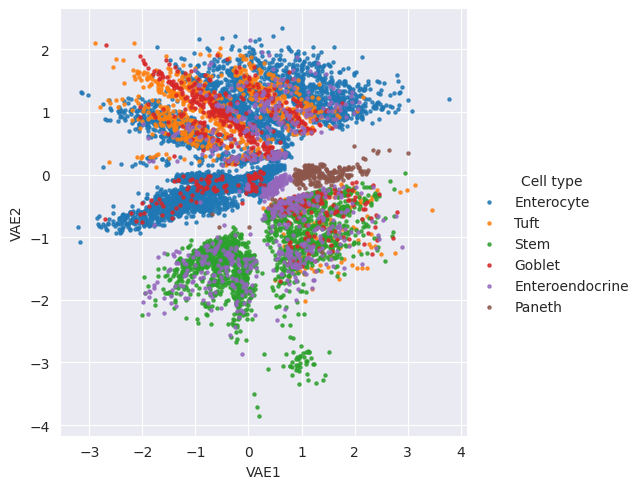

In [13]:
sns.lmplot( x="VAE1", y="VAE2",
  data=reduced_dims.head(10000),
  fit_reg=False,
  hue='Cell type', # color by cluster
  legend=True,
  scatter_kws={"s": 5})